In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcess
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn import cross_validation
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
from random import randrange
import time
import os
import itertools

%matplotlib inline

In [23]:
#Read the data file and separate the data into features and labels
data = pd.read_csv('input/dataset.csv')

data.drop(['id'], axis=1, inplace=True)

labels = data['target']
features = data.drop(['target'], axis=1)

data.head()
print('Dataset has {} datapoints with {} features'.format(*features.shape))

Dataset has 61878 datapoints with 93 features


# Data Exploration and Pre-Processing

#### 1. Label encoding
#### 2. Distribution of data in different classes
#### 3. Statistics for each feature

In [24]:
#Label Encoder - Transform the target values into class labels from 0-8
le = LabelEncoder()
labels = le.fit_transform(labels)
labels[0:5]

array([0, 0, 0, 0, 0], dtype=int64)

1    0.260545
5    0.228433
7    0.136785
2    0.129351
8    0.080077
6    0.045881
4    0.044265
3    0.043489
0    0.031174
dtype: float64

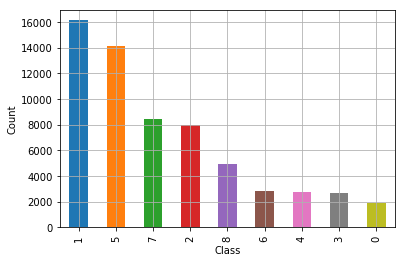

In [25]:
#Distribution of data points in different classes
ax = pd.Series(labels).value_counts().plot(kind='bar', grid=True)
ax.set_xlabel("Class")
ax.set_ylabel("Count")
ax.get_figure().savefig("class_distribution.png")
pd.Series(labels).value_counts(normalize=True)

In [26]:
#Statistical distribution of the dataset
features_stats = features.describe().transpose()
features_stats.to_csv('features_stats.csv')

In [43]:
#Normalize features using log transformation
features_log = features.apply(lambda x: np.log(x + 1))

In [28]:
features_log_stats = features_log.describe()
features_log_stats.to_csv('features_log_stats.csv')

In [29]:
features_log.head().to_csv('features_log.csv')

# Dimensionality Reduction using PCA

In [30]:
pca = PCA(n_components=len(features_log.keys()))
pca.fit(features_log)
exp_var = pca.explained_variance_ratio_

In [42]:
# Get cumulative variance for successive principal components
def sum_(x):
    return sum(x)

cum_var = pd.expanding_apply(exp_var, sum_)


C:\Supriti\PythonFolder\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.expanding_apply is deprecated for ndarrays and will be removed in a future version


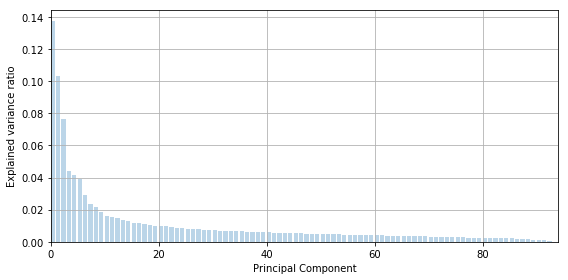

In [32]:
plt.figure(figsize=(8, 4))
plt.bar(range(93), exp_var, alpha=0.3, align='edge',label='Explained Variance %')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal Component')
plt.xlim([0,94])
plt.grid()
plt.tight_layout()
#ax.get_figure().savefig("PC_variance.png")
plt.savefig("PC_variance.png")

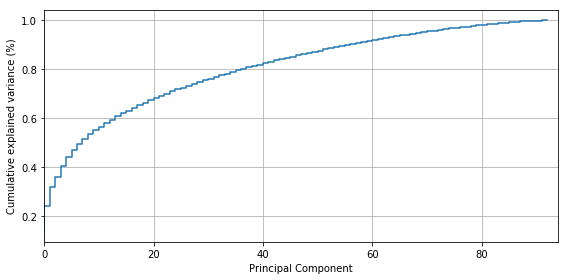

In [33]:
plt.figure(figsize=(8, 4))
plt.step(range(93), cum_var, label='Explained Variance %')
plt.ylabel('Cumulative explained variance (%)')
plt.xlabel('Principal Component')
plt.xlim([0,94])
plt.grid()
plt.tight_layout()
plt.savefig("cum_variance.png")

### Split Training and Testing datasets

In [34]:
sss = StratifiedShuffleSplit(y = labels, n_iter=1, test_size=0.20, random_state=0)
len(sss)
for train_ix, test_ix in sss:
    train_x = features_log.loc[train_ix]
    train_y = labels[train_ix]
    test_x = features_log.loc[test_ix]
    test_y = labels[test_ix]
    print('Number of training samples: {}'.format(len(train_ix)))
    print('Number of test samples: {}'.format(len(test_ix)))

Number of training samples: 49502
Number of test samples: 12376


### Evaluation Metric : Log Loss Function

In [35]:
def log_loss_metric(y_true, y_pred):
    loss = log_loss(y_true, y_pred)
    return loss

### Classification Models with original features

In [40]:
#Function to train models using grid search cv
def cv_model_train(model, parameters, file_name):
    grid_obj = GridSearchCV(model, parameters, scoring='log_loss')
    grid_fit = grid_obj.fit(train_x, train_y)
    best_model = grid_fit.best_estimator_
    pred = best_model.predict_proba(test_x)
    print(log_loss_metric(test_y, pred))
    joblib.dump(best_model, file_name)
    return grid_fit

In [41]:
#Function to plot the model scores
def plot_scores(scores, labels, max_y, save_file):
    colors = ['#FFC300','#FF5733','#C70039', '#581845']
    width=0.7
    for i in range(len(scores)):
        plt.bar(i+1, scores[i], width=width, color=colors[i], label=labels[i])
    plt.legend(loc='best')
    plt.xticks(np.arange(1, 5, 1))
    plt.ylabel('Log Loss')
    plt.xlabel('Model')
    plt.ylim([0,max_y])
    plt.grid()
    plt.tight_layout()
    plt.savefig(save_file)

In [26]:
#Random Forest
parameters = {'n_estimators':[250, 400], 'max_depth':[7, 9]}
clf_rf = RandomForestClassifier(min_samples_split=20, min_samples_leaf=10, random_state=0)
grid_rf = cv_model_train(clf_rf, parameters, 'models/rf/rf1.pkl')

C:\Supriti\PythonFolder\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Supriti\PythonFolder\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Supriti\PythonFolder\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Supriti\PythonFolder\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Supriti\PythonFolder\Anaconda3\lib\site-packages\sklearn\metrics\scorer.p

1.00876093612


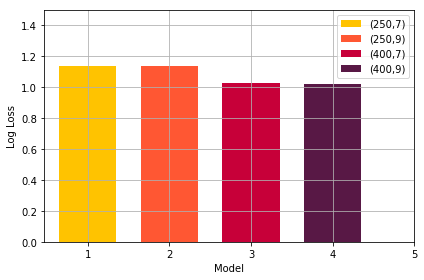

In [85]:
scores = [-x[1] for x in grid_rf.grid_scores_]
labels = ['(250,7)', '(250,9)', '(400,7)', '(400,9)']
plot_scores(scores, labels, 1.5, "RF_cross_val.png")

In [38]:
knn_params = {'n_neighbors':[50, 100, 500, 1000]}
clf_knn_best = KNeighborsClassifier(weights='distance')
grid_knn = cv_model_train(clf_knn_best, knn_params, 'models/knn/knn_best.pkl')

C:\Supriti\PythonFolder\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Supriti\PythonFolder\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Supriti\PythonFolder\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Supriti\PythonFolder\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Supriti\PythonFolder\Anaconda3\lib\site-packages\sklearn\metrics\scorer.p

0.654566014399


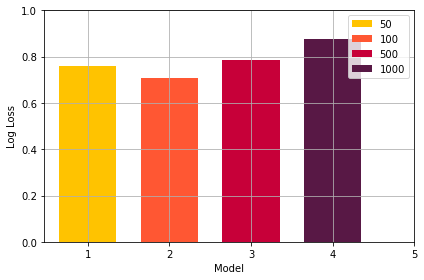

In [86]:
scores = [-x[1] for x in grid_knn.grid_scores_]
labels = ['50', '100', '500', '1000']
plot_scores(scores, labels, 1, "KNN_cross_val.png")

In [14]:
parameters_xgb = {'learning_rate':[0.5, 1, 1.5], 'min_samples_leaf': [10], 'max_depth':[9]}
clf_xgb = GradientBoostingClassifier(random_state=0, n_estimators=300)
grid_xgb = cv_model_train(clf_xgb, parameters_xgb, 'models/xgb_best/xgb.pkl')

C:\Supriti\PythonFolder\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Supriti\PythonFolder\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Supriti\PythonFolder\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Supriti\PythonFolder\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Supriti\PythonFolder\Anaconda3\lib\site-packages\sklearn\metrics\scorer.p

1.07277794224


[1.2239011575899816, 7.143574521726368, 33.06308829998048]


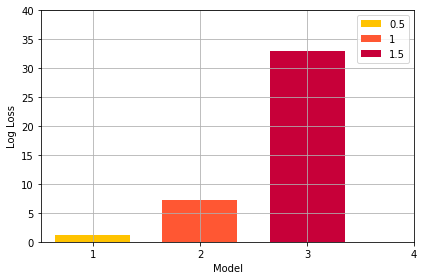

In [20]:
scores = [-x[1] for x in grid_xgb.grid_scores_]
print(scores)
labels = ['0.5', '1', '1.5']
plot_scores(scores, labels, 40, "XGB_cross_val.png")

In [37]:
parameters_adb = {'learning_rate':[0.5, 1.5], 'n_estimators':[200,400]}
clf_adb = AdaBoostClassifier(random_state=0)
grid_adb = cv_model_train(clf_adb, parameters_adb, 'models/adb_best/adb.pkl')

C:\Supriti\PythonFolder\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Supriti\PythonFolder\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Supriti\PythonFolder\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Supriti\PythonFolder\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Supriti\PythonFolder\Anaconda3\lib\site-packages\sklearn\metrics\scorer.p

2.08343502845


[2.08136274127754, 2.1032094265246837, 2.0677723724318193, 2.0636890900634133]


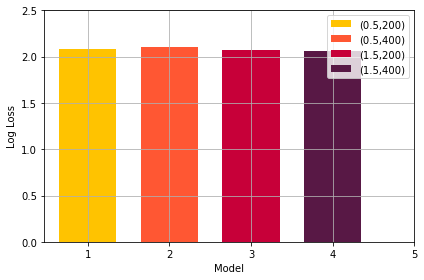

In [88]:
scores = [-x[1] for x in grid_adb.grid_scores_]
labels = ['(0.5,200)', '(0.5,400)', '(1.5,200)', '(1.5,400)']
plot_scores(scores, labels, 2.5, "ADB_cross_val.png")
print(scores)

### Ensemble Learning

In [38]:
rf = joblib.load('models/rf/rf1.pkl')
knn = joblib.load('models/knn/knn_best.pkl')
xgb = joblib.load('models/xgb_best/xgb.pkl')
adb = joblib.load('models/adb_best/adb.pkl')

In [40]:
eclf1 = VotingClassifier(estimators=[('rf', rf), ('knn', knn), ('xgb', xgb)], voting='soft', weights=[1,1,1])
eclf1.fit(train_x, train_y)

VotingClassifier(estimators=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=20,
            min_wei...         presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='soft',
         weights=[1, 1, 1])

In [41]:
eclf1_pred =eclf1.predict_proba(test_x)
print(log_loss_metric(test_y, eclf1_pred))

0.618313107235


In [42]:
joblib.dump(eclf1, 'models/ensemble/eclf1.pkl')

['models/ensemble/eclf1.pkl']

In [37]:
eclf2 = VotingClassifier(estimators=[('rf', rf), ('knn', knn), ('xgb', xgb)], voting='soft', weights=[1,2,1])
eclf2.fit(train_x, train_y)

VotingClassifier(estimators=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=20,
            min_wei...         presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='soft',
         weights=[1, 2, 1])

In [38]:
#eclf2 = joblib.load('models/ensemble/eclf2.pkl')
eclf2_pred =eclf2.predict_proba(test_x)
print(log_loss_metric(test_y, eclf2_pred))

0.602342956849


In [93]:
joblib.dump(eclf2, 'models/ensemble/eclf2.pkl')

['models/ensemble/eclf2.pkl']

In [94]:
eclf3 = VotingClassifier(estimators=[('rf', rf), ('knn', knn), ('xgb', xgb)], voting='soft', weights=[2,4,1])
eclf3.fit(train_x, train_y)

VotingClassifier(estimators=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=20,
            min_wei...         presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='soft',
         weights=[2, 4, 1])

In [95]:
eclf3_pred =eclf3.predict_proba(test_x)
print(log_loss_metric(test_y, eclf3_pred))

0.633169358723


In [96]:
joblib.dump(eclf3, 'models/ensemble/eclf3.pkl')

['models/ensemble/eclf3.pkl']

In [98]:
eclf4 = VotingClassifier(estimators=[('rf', rf), ('knn', knn), ('xgb', xgb), ('adb', adb)], voting='soft', weights=[1,2,1, 0.5])
eclf4.fit(train_x, train_y)

VotingClassifier(estimators=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=20,
            min_wei...thm='SAMME.R', base_estimator=None,
          learning_rate=1.5, n_estimators=400, random_state=0))],
         flatten_transform=None, n_jobs=1, voting='soft',
         weights=[1, 2, 1, 0.5])

In [99]:
eclf4_pred =eclf4.predict_proba(test_x)
print(log_loss_metric(test_y, eclf4_pred))

0.681799381104


In [100]:
joblib.dump(eclf4, 'models/ensemble/eclf4.pkl')

['models/ensemble/eclf4.pkl']

In [18]:
eclf5 = VotingClassifier(estimators=[('rf', rf), ('knn', knn), ('xgb', xgb), ('adb', adb)], voting='soft', weights=[1,1,1,1])
eclf5.fit(train_x, train_y)

VotingClassifier(estimators=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=20,
            min_wei...thm='SAMME.R', base_estimator=None,
          learning_rate=1.5, n_estimators=400, random_state=0))],
         flatten_transform=None, n_jobs=1, voting='soft',
         weights=[1, 1, 1, 1])

In [19]:
eclf5_pred =eclf5.predict_proba(test_x)
print(log_loss_metric(test_y, eclf5_pred))
joblib.dump(eclf5, 'models/ensemble/eclf5.pkl')

0.809912065425


['models/ensemble/eclf5.pkl']

In [20]:
eclf6 = VotingClassifier(estimators=[('rf', rf), ('knn', knn)], voting='soft', weights=[1,2])
eclf6.fit(train_x, train_y)

VotingClassifier(estimators=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=20,
            min_wei...ki',
           metric_params=None, n_jobs=1, n_neighbors=100, p=2,
           weights='distance'))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=[1, 2])

In [21]:
eclf6_pred =eclf6.predict_proba(test_x)
print(log_loss_metric(test_y, eclf6_pred))
joblib.dump(eclf6, 'models/ensemble/eclf6.pkl')

0.688280394782


['models/ensemble/eclf6.pkl']

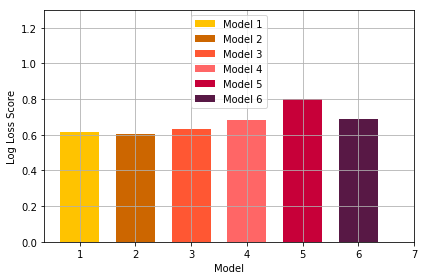

In [35]:
ensemble_scores = [0.6183,0.6023,0.6332,0.6818,0.8010,0.6883]
cat = [1,2,3,4,5,6]
colors = ['#FFC300',"#CC6600",'#FF5733',"#FF6666",'#C70039', '#581845']
width=0.7
labels=['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6']
for i in range(len(ensemble_scores)):
    plt.bar(i+1, ensemble_scores[i], width=width, color=colors[i], label=labels[i])
plt.legend(loc='upper center')
plt.xticks(np.arange(1, 8, 1))
plt.ylabel('Log Loss Score')
plt.xlabel('Model')
plt.ylim([0,1.3])
plt.grid()
plt.tight_layout()
plt.savefig('ensemble_scores.png')


## Confusion Matrix

In [51]:
y_pred = np.argmax(eclf2_pred, axis=1)
cnf_matrix=confusion_matrix(test_y, y_pred)

In [56]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[  3.96373057e-01   6.21761658e-02   5.18134715e-03   0.00000000e+00
    1.03626943e-02   8.54922280e-02   2.07253886e-02   1.76165803e-01
    2.43523316e-01]
 [  0.00000000e+00   8.96712159e-01   9.08808933e-02   3.10173697e-03
    2.17121588e-03   2.17121588e-03   3.41191067e-03   3.10173697e-04
    1.24069479e-03]
 [  6.24609619e-04   5.49031855e-01   4.18488445e-01   1.18675828e-02
    0.00000000e+00   6.24609619e-04   1.56152405e-02   2.49843848e-03
    1.24921924e-03]
 [  0.00000000e+00   4.73977695e-01   1.41263941e-01   3.38289963e-01
    5.57620818e-03   2.41635688e-02   1.30111524e-02   1.85873606e-03
    1.85873606e-03]
 [  0.00000000e+00   2.55474453e-02   1.82481752e-03   0.00000000e+00
    9.63503650e-01   3.64963504e-03   1.82481752e-03   0.00000000e+00
    3.64963504e-03]
 [  2.12239123e-03   1.83940573e-02   7.07463742e-04   7.07463742e-04
    1.06119561e-03   9.37035727e-01   1.20268836e-02   1.37955430e-02
    1.41492748e-02]
 [  1.056338

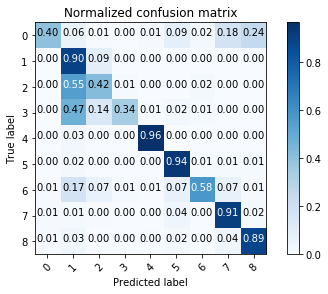

In [58]:
class_names = [i for i in range(0,9)]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.savefig('confusion_matrix.png')
plt.show()

### Benchmark Model

#### Worst Case: Random Guess - Naive classifier


In [39]:
#Evaluating a 'Naive' classifier
num_of_samples = len(labels)
random_pred = []

for i in range(num_of_samples):
    pred = np.zeros((9))
    pred[randrange(0,8)]=1.0
    random_pred.append(pred)

rand_guess_loss = log_loss_metric(labels, random_pred)
print("Log loss with randomly classifying a product into different categories is {}".format(rand_guess_loss))

Log loss with randomly classifying a product into different categories is 30.528844438140307
